# Segment 3
## Motivation
In this notebook, we explore neuron-level interpretability in a classic convolutional neural network: InceptionV1. Our guiding questions are:

- What kinds of visual patterns activate individual neurons?

- Are these patterns reflected in real images from a dataset?

- Can the synthetic visualizations help us build intuition about what natural images will activate strongly?

To answer this, we will:

1. Select neurons from an intermediate layer (mixed_4a)

2. Generate activation-maximizing images for those neurons

3. Search a dataset for real images that strongly activate the same neurons

4. Visualize and analyze the resulting patterns

## Background Concepts
### What is a "neuron" in a CNN?

In convolutional networks, a neuron corresponds to one channel (feature map) in a convolutional layer. Each neuron responds to specific visual patterns such as edges or orientations (early layers), textures or shapes (middle layers) or object parts or concepts (later layers).

### Why `mixed_4a`?

InceptionV1’s mixed_4a layer sits roughly in the middle of the network, a sweet spot for studying emergent visual features. If it were too early, the detection would be mostly low-level edges, and if it were too late it would be highly abstract object concepts.

## Imports and Reproducibility
We start by fixing all random seeds to make sure the results are reproducible

In [1]:
import torch
import numpy as np
import random
import os
from pathlib import Path
from typing import Dict, List, Tuple
import heapq

import matplotlib.pyplot as plt
from PIL import Image

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset

from lucent.optvis import render, param, transform, objectives
from lucent.modelzoo import inceptionv1

In [2]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## The Data

This section is dedicated to streaming our ImageNet sample images from HuggingFace. Streaming is used due to the size of the dataset (~150GB), which makes downloading prohibitive for limited space. Streaming allows us to pull the samples sequentially via HTTP, process each sample at a time, then discard them. 

In [12]:
from datasets import load_dataset

class ImageNetStreamer:
    def __init__(self, batch_size=32, max_images=2000):
        self.batch_size = batch_size
        self.max_images = max_images
        self.device = self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.ds = load_dataset(
            "ILSVRC/imagenet-1k",
            streaming=True
        )

        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])

    def preprocess(self, image):
        if image.mode != "RGB":
            image = image.convert("RGB")
        return self.transform(image)

    def stream_split(self, split):
        batch_imgs, batch_labels = [], []

        count = 0
        for sample in self.ds[split]:
            #if self.max_images is not None and count >= self.max_images:
            #    break

            img = self.preprocess(sample["image"])
            batch_imgs.append(img)
            batch_labels.append(sample["label"])
            count += 1
            if count % 1000 == 0:
                print(f"Streamed {count} images from {split} set.")

            if len(batch_imgs) == self.batch_size:
                yield (
                    torch.stack(batch_imgs).to(self.device),
                    torch.tensor(batch_labels).to(self.device),
                )
                batch_imgs, batch_labels = [], []

    def __iter__(self):
        for split in ["validation"]:
            yield from self.stream_split(split)


## The `Analyzer` Class
To keep the notebook clean and modular, we wrap the full pipeline inside an `Analyzer`class. We use it to load the model, extract the activations, optimize images, search the dataset and visualize the results.

In [9]:
class Analyzer:
    """
    A utility class for neuron-level interpretability analysis
    in InceptionV1 using activation maximization and dataset search.
    """

    def __init__(self, target_layer, device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        self.model = None
        self.target_layer = target_layer
        self.selected_neuron = None

        # Dictionary used to store activations captured by hooks
        self.activations = {}

        self.load_model()

        # Standard ImageNet preprocessing
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def load_model(self):
        """
        Loads a pretrained InceptionV1 model
        and sets it to evaluation mode.
        """
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = inceptionv1(pretrained=True).to(device).eval()

    def set_selected_neuron(self, neuron: int):
        """
        Sets the neuron (channel index) to be analyzed.
        """
        self.selected_neuron = neuron

    def get_layer_info(self) -> Dict:
        """
        Retrieves the module corresponding to the target layer name.
        """
        target_module = None
        for name, module in self.model.named_modules():
            if name == self.target_layer:
                target_module = module
                break

        if target_module is None:
            raise ValueError(f"Layer {self.target_layer} not found in model")

        return {
            'name': self.target_layer,
            'module': target_module
        }

    # As we've seen in previous segments, activation maximization is a technique used to generate input images that maximize the activation of specific neurons within a neural network. 
    # This is typically done through gradient-based optimization, where we start with a random image and iteratively adjust it to increase the activation of the target neuron. 
    # The resulting images can provide insights into what features or patterns the neuron is responsive to, helping us understand the internal workings of the model.

    def activation_maximization(self, neuron, steps: int = 512, lr: float = 0.05) -> torch.Tensor:
        """
        Generates an image that maximally activates a given neuron
        using gradient-based optimization.
        """
        self.set_selected_neuron(neuron)

        # Objective: maximize a specific channel in a specific layer
        obj = objectives.channel(self.target_layer, self.selected_neuron)

        # Small transformations prevent the optimization from producing high-frequency artifacts, and encourage more interpretable patterns.
        transform_list = [
            transform.pad(12),
            transform.jitter(8),
            transform.random_scale([0.9, 0.95, 1.05, 1.1]),
            transform.random_rotate([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]),
            transform.jitter(2)
        ]

        # Using an FFT-based parameterization biases the optimization towards more natural-looking structures.
        def param_f(lr: float = 0.05):
            return param.image(224, fft=True, decorrelate=True)
        
        result = render.render_vis(
            self.model,
            obj,
            param_f=param_f,
            transforms=transform_list,
            thresholds=(steps,),
            show_inline=False
        )

        optimized_image = result[0]
        return optimized_image
    
    # To measure neuron responses to real images, we attach a forward hook to the target layer.
    def setup_activation_hook(self):
        """
        Registers a forward hook to capture activations
        from the target layer during inference.
        """
        def hook_fn(module, input, output):
            self.activations[self.target_layer] = output

        for name, module in self.model.named_modules():
            if name == self.target_layer:
                module.register_forward_hook(hook_fn)
                break

    def get_neuron_activation(self, image: torch.Tensor) -> float:
        """
        Computes the mean activation value of the selected neuron
        for a given image.
        """
        with torch.no_grad():
            if len(image.shape) == 3:
                image = image.unsqueeze(0)

            image = image.to(self.device)
            _ = self.model(image)

            layer_activation = self.activations[self.target_layer]
            neuron_activation = layer_activation[0, self.selected_neuron]

            # Average over spatial dimensions
            return neuron_activation.mean().item()
        
    # Instead of a single number, we can also inspect where the neuron fires spatially.
    def get_neuron_activation_map(self, image: torch.Tensor) -> np.ndarray:
        """
        Returns a normalized spatial activation map
        for the selected neuron.
        """
        image = image.unsqueeze(0).to(self.device)
        with torch.no_grad():
            _ = self.model(image)
        act = self.activations[self.target_layer][0, self.selected_neuron]
        return act.cpu().numpy()
        
    # We can now search the dataset to find real images that strongly activate the neuron.
    def find_highly_activating_images(self, top_k: int = 10):
        
        self.setup_activation_hook()
        streamer = ImageNetStreamer(batch_size=64, max_images=100)

        top_heap = []

        for batch_images, batch_labels in streamer:
            batch_images = batch_images.to(self.device)

            with torch.no_grad():
                _ = self.model(batch_images)

            # (B, C, H, W)
            acts = self.activations[self.target_layer]

            # Select neuron → (B, H, W)
            neuron_acts = acts[:, self.selected_neuron]

            # Global max pool → (B,)
            scores = neuron_acts.flatten(1).max(dim=1).values

            scores_cpu = scores.cpu()

            for i, score in enumerate(scores_cpu):
                item = (score.item(), batch_images[i].cpu())

                if len(top_heap) < top_k:
                    heapq.heappush(top_heap, item)
                else:
                    heapq.heappushpop(top_heap, item)

        # Sort descending
        top_images = sorted(top_heap, key=lambda x: x[0], reverse=True)
        return top_images
    
    # Finally, we tie everything together
    def run_complete_analysis(self,
                              neuron: int = 0,
                              optim_steps: int = 512) -> Dict:

        print("\nStep 1: Performing activation maximization...")
        optimized_image = self.activation_maximization(neuron, steps=optim_steps)

        print("\nStep 2: Finding highly activating dataset images...")
        top_images = self.find_highly_activating_images()

        return {"neuron": neuron,
                "optimized_image": optimized_image,
                "top_images": top_images}


## What to Look For in the Results
As you explore different neurons, ask:

- Does the activation maximization and the real images share visual motifs?

- Is the neuron sensitive to color, texture, shape, or structure?

- Are activation maps localized or diffuse?

In [13]:
analyzer = Analyzer(target_layer="mixed4a")

analysis = analyzer.run_complete_analysis(
        neuron=6,
        optim_steps=128
    )


Step 1: Performing activation maximization...


100%|██████████| 128/128 [01:00<00:00,  2.12it/s]



Step 2: Finding highly activating dataset images...
Streamed 1000 images from validation set.
Streamed 2000 images from validation set.
Streamed 3000 images from validation set.
Streamed 4000 images from validation set.
Streamed 5000 images from validation set.
Streamed 6000 images from validation set.
Streamed 7000 images from validation set.
Streamed 8000 images from validation set.
Streamed 9000 images from validation set.
Streamed 10000 images from validation set.
Streamed 11000 images from validation set.
Streamed 12000 images from validation set.
Streamed 13000 images from validation set.
Streamed 14000 images from validation set.
Streamed 15000 images from validation set.
Streamed 16000 images from validation set.
Streamed 17000 images from validation set.
Streamed 18000 images from validation set.
Streamed 19000 images from validation set.
Streamed 20000 images from validation set.
Streamed 21000 images from validation set.
Streamed 22000 images from validation set.
Streamed 2

## Visualizing a Single Neuron

We begin by focusing on **one individual neuron (channel)** in an intermediate convolutional layer.  
The goal of this visualization is to build intuition about what this neuron responds to, using two complementary views:

1. **Activation maximization** – a synthetic image optimized to strongly activate the neuron.
2. **Top activating real images** – samples from the dataset that naturally elicit high activation.

The optimized image (shown at the top) represents *what the neuron “wants to see”* in isolation, under the model’s learned constraints.  
Below it, we show the top real dataset images ranked by their activation strength for this neuron.

By comparing the synthetic and real images, we can ask:
- Does the optimized image resemble patterns found in real data?
- Is the neuron responding to color, texture, shape, or object parts?
- Are the top activating images visually coherent, or diverse?

This single-neuron view serves as a grounding example before scaling the analysis to multiple neurons.


In [ ]:
# Our function returns a tensor, so we need to convert it to a format that can be displayed with plt.imshow.
def tensor_to_imshow(img):
        """
        Converts a torch tensor or numpy array into a format usable by plt.imshow.
        Expected input: (3, H, W) or (1, 3, H, W)
        Output: (H, W, 3) in [0, 1]
        """
        if isinstance(img, torch.Tensor):
            img = img.detach().cpu().numpy()

        # Remove batch dim if present
        if img.ndim == 4:
            img = img[0]

        # CHW -> HWC
        if img.shape[0] == 3:
            img = np.transpose(img, (1, 2, 0))

        # If normalized (ImageNet), roughly unnormalize
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)

        return img

# This step creates the visualization in a structured manner.
def visualize_results_grid(analysis, top_k=10):

        optimized_image = analysis["optimized_image"]
        top_images = analysis["top_images"][:top_k]
        neuron = analysis.get("neuron", "?")

        fig = plt.figure(figsize=(18, 10))
        gs = fig.add_gridspec(3, 5, height_ratios=[2.2, 1, 1])

        # Showing the optimized image
        ax_opt = fig.add_subplot(gs[0, :])
        opt_img = tensor_to_imshow(optimized_image)
        ax_opt.imshow(opt_img)
        ax_opt.set_title(
            f"Activation Maximization – Neuron {neuron}",
            fontsize=16,
            fontweight="bold"
        )
        ax_opt.axis("off")

        # Showing the top activating dataset images
        for i, (score, img_tensor) in enumerate(top_images):
            row = 1 + i // 5
            col = i % 5

            ax = fig.add_subplot(gs[row, col])
            img = tensor_to_imshow(img_tensor)

            ax.imshow(img)
            ax.set_title(f"#{i+1}\n{score:.1f}", fontsize=10)
            ax.axis("off")

        plt.tight_layout()
        plt.show()

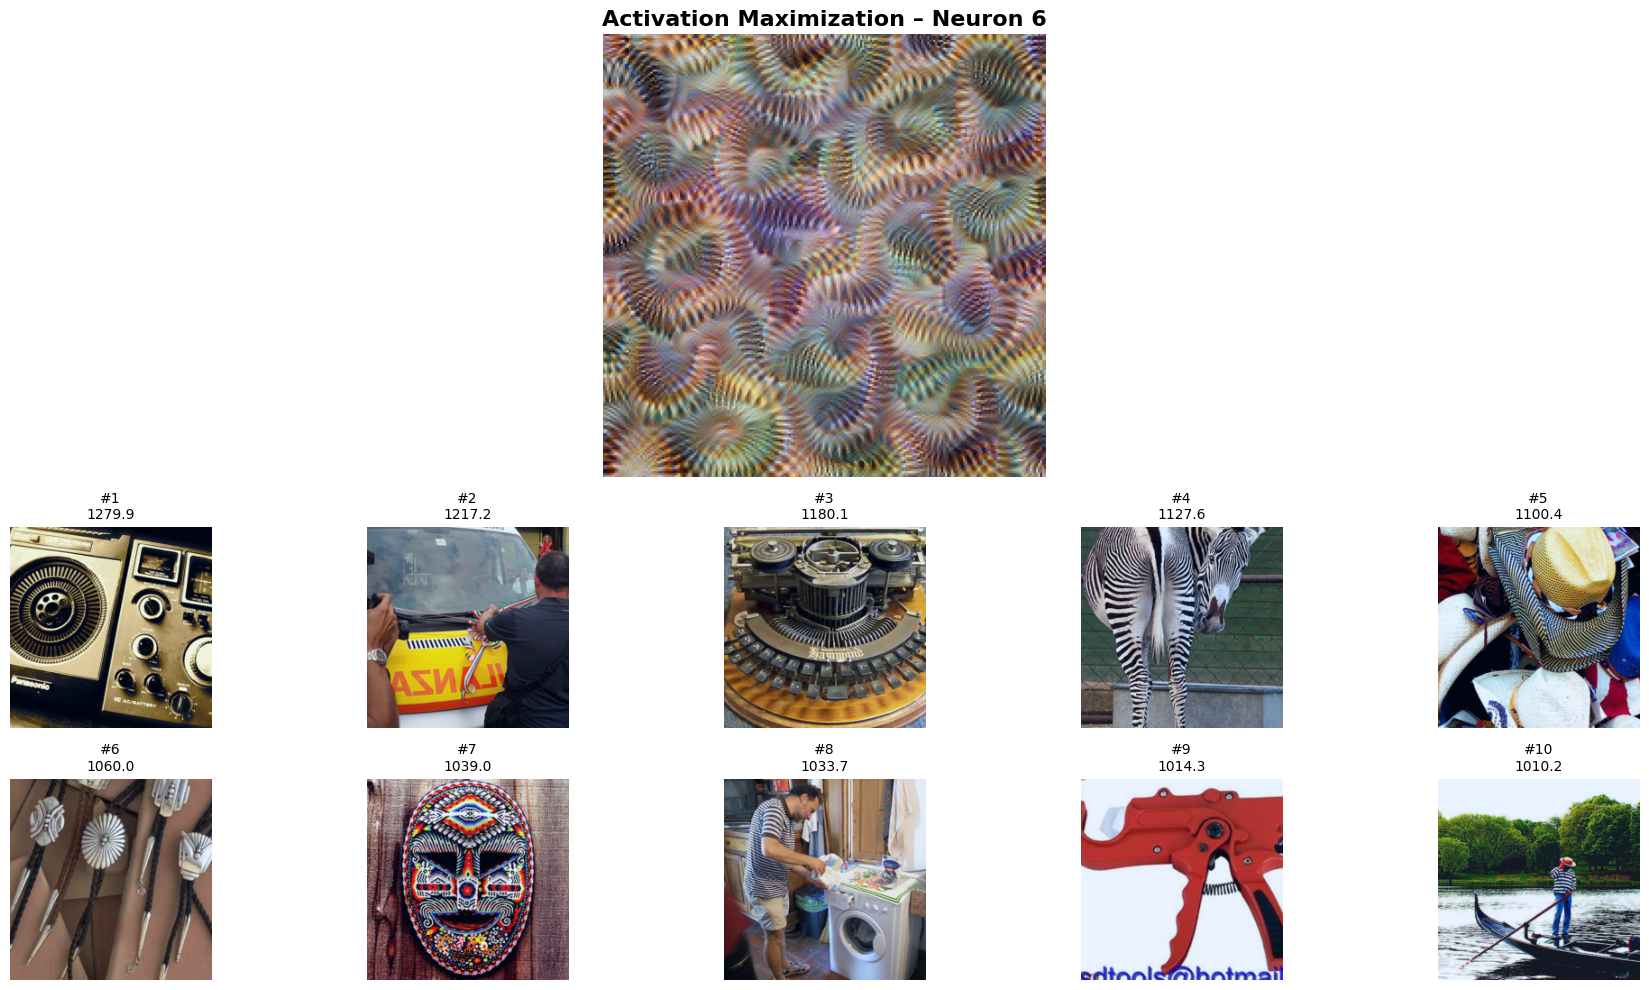

In [15]:
visualize_results_grid(analysis)

## Visualizing Multiple Neurons

After examining a single neuron in detail, we extend the analysis to **multiple neurons (ten channels)** from the same layer.

For each neuron, we visualize:
- The **activation maximization image**, showing the feature configuration that most strongly excites the neuron.
- The **top activating real images**, sampled from the dataset and ranked by activation strength.

Presenting multiple neurons side by side allows us to observe how representations **diversify** within a single layer.  
Even though these neurons share the same spatial resolution and receptive field size, they often specialize in distinct visual features.

This comparison helps answer broader questions about the layer’s internal structure:
- Do different neurons capture variations of a similar concept, or entirely different ones?
- Are some neurons highly specific, while others respond more broadly?
- How interpretable are the learned features at this depth of the network?

Rather than aiming for definitive semantic labels, this visualization should be read as an **exploratory probe** into the model’s internal representations—highlighting patterns, regularities, and occasional surprises.

In [ ]:
analyzer = Analyzer(target_layer="mixed4a")

all_results = {}

for neuron_id in range(0, 10):
    print("=" * 60)
    print(f"Analyzing neuron {neuron_id} in layer mixed_4a")
    print("=" * 60)

    analysis = analyzer.run_complete_analysis(
        neuron=neuron_id,
        optim_steps=128
    )

    all_results[neuron_id] = analysis